In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from mpl_toolkits.mplot3d import Axes3D
%pylab inline
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Building a GP emulator using tensorflow
 
Tensorflow is known as a deep learning library used by Google Brain. Tensorflow probability recently gained more and more users (the recent implementation of StarFish in exoplanet community). It would be interesting to test how well the emulator framework in cosmology can fit into the modern tensorflow probability pipeline.

Below we follow the tutorial posted in tensorflow probability official website: https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP

It constitutes a few topics:
1. Exact GP Regression using maximum a posteriori (MAP) estimation
2. Marginalizing hyperparameters using HMC

I will keep the comments from tensorflow in the code cells. But delete most of the markdown cells.

## Prepare Power Spectrum data

Power spectrum, P(k), is the Fourier Transform of the correlation function in the Universe. It describes the variance of the matter density field as a function of k. k is in unit of inverse length, which means small k describes longer distances and large k describes shorter distances. Thus, large P(k) at large k means there are more structures (more variance) at the large scales (longer distances).

Below, we use the power spectrum from dark-matter only simulations.

In [2]:
# Fourier k modes
kf = np.loadtxt("../data/360_res128box256_9_res512box256_z0/kf.txt")

# X is the input cosmological parameters, (Omega_m, Omega_0, h, A_s, n_s)
X = np.loadtxt("../data/360_res128box256_9_res512box256_z0/train_input_fidelity_0.txt")
# lower and upper bounds (prior volume) of the cosmological parameters
param_limits = np.loadtxt("../data/360_res128box256_9_res512box256_z0/input_limits.txt")

# Y is the power spectrum, P(k)
Y = np.loadtxt("../data/360_res128box256_9_res512box256_z0/train_output_fidelity_0.txt")


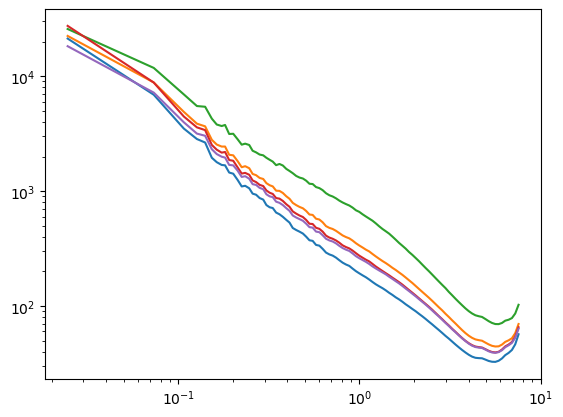

In [3]:
plt.loglog(
    10**kf, 10**Y[:5, :].T
);

It is essential to normalize both the input and outputs. Because we will be using the same LogNormal priors for lengthscales and amplitudes for each parameter and each k bin. We don't want the prior to bias the inferred hyperparameters in a certain dimension of k bin.

In [4]:
def map_to_unit_cube(param_vec, param_limits):
    """
    Map a parameter vector to the unit cube from the original dimensions of the space.
    Arguments:
    param_vec - the vector of parameters to map.
    param_limits - the limits of the allowed parameters.
    Returns:
    vector of parameters, all in [0,1].
    """
    assert (np.size(param_vec),2) == np.shape(param_limits)
    assert np.all(param_vec-1e-16 <= param_limits[:,1])
    assert np.all(param_vec+1e-16 >= param_limits[:,0])
    ii = np.where(param_vec > param_limits[:,1])
    param_vec[ii] = param_limits[ii,1]
    ii = np.where(param_vec < param_limits[:,0])
    param_vec[ii] = param_limits[ii,0]
    assert np.all(param_limits[:,0] <= param_limits[:,1])
    new_params = (param_vec-param_limits[:,0])/(param_limits[:,1] - param_limits[:,0])
    assert np.all((new_params >= 0)*(new_params <= 1))
    return new_params

def map_to_unit_cube_list(param_vec_list, param_limits):
    """Map multiple parameter vectors to the unit cube"""
    return np.array([map_to_unit_cube(param_vec, param_limits) for param_vec in param_vec_list])

def input_normalize(
    params: np.ndarray, param_limits: np.ndarray
) -> np.ndarray:
    """
    Map the parameters onto a unit cube so that all the variations are
    similar in magnitude.
    
    :param params: (n_points, n_dims) parameter vectors
    :param param_limits: (n_dim, 2) param_limits is a list 
        of parameter limits.
    :return: params_cube, (n_points, n_dims) parameter vectors 
        in a unit cube.
    """
    nparams = np.shape(params)[1]
    params_cube = map_to_unit_cube_list(params, param_limits)
    assert params_cube.shape[1] == nparams

    return params_cube


In [5]:
# Normalize input to a [0 - 1] Latin Hypercube
# This is to avoid the lengthscale & amplitude prior
# to hard to define
X = input_normalize(X, param_limits=param_limits)

In [6]:
# Normalized: Here we substract the P(k) with its mean at a certain k,
# P(k= k') <- P(k= k') - Mean(P(k = k')) 
Y_mean = Y.mean(axis=0)
_Y_old = Y
Y = (Y - Y_mean)

# The transpose here is to fit the convention of tensorflow, which wants Y in dimension of
# (num of outputs, num of examples)
Y = Y.T

# keep some samples for testing
X_test = X[:60, :]
Y_test = Y[:, :60]

# Only use part of them for training
X = X[60:120, :]
Y = Y[:, 60:120]

In [7]:
num_examples, num_features = X.shape
num_outputs, num_examples  = Y.shape

X.shape, Y.shape

((60, 5), (96, 60))

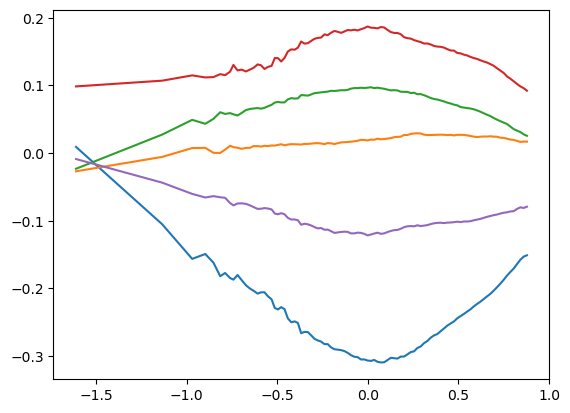

In [8]:
plt.plot(
    kf, Y[:, :5]
);

## Build your GP with tensorflow

We want our GP to have Automatic Relevance Determination, which means one lengthscale per feature dimension. This is not implemented in tensorflow probability yet (by the time I wrote the notebook).

The Issue in this thread asked by StarFish team provided a custom ARD kernel (https://github.com/tensorflow/probability/issues/248), which we will be using here.

In [9]:
class InputTransformedKernel(tfk.PositiveSemidefiniteKernel):

  def __init__(self, kernel, transformation, name='InputTransformedKernel'):
    self._kernel = kernel
    self._transformation = transformation
    super(InputTransformedKernel, self).__init__(
        feature_ndims=kernel.feature_ndims,
        dtype=kernel.dtype,
        name=name)

  def apply(self, x1, x2):
    return self._kernel.apply(
        self._transformation(x1),
        self._transformation(x2))

  def matrix(self, x1, x2):
    return self._kernel.matrix(
        self._transformation(x1),
        self._transformation(x2))

  @property
  def batch_shape(self):
    return self._kernel.batch_shape

  def batch_shape_tensor(self):
    return self._kernel.batch_shape_tensor

class InputScaledKernel(InputTransformedKernel):

  def __init__(self, kernel, length_scales):
    super(InputScaledKernel, self).__init__(
        kernel,
        lambda x: x / tf.expand_dims(length_scales,
                                     -(kernel.feature_ndims + 1)))


$$
\begin{align}
f \sim \: & \textsf{GaussianProcess}\left(
    \text{mean_fn}=\mu(x),
    \text{covariance_fn}=k(x, x')\right) \\
y_i \sim \: & \textsf{Normal}\left(
    \text{loc}=f(x_i),
    \text{scale}=\sigma\right), i = 1, \ldots, N
\end{align}
$$

$$
\textsf{lengthscale} \sim \textsf{LogNormal}(\mu, \sigma)\\
\textsf{amplitude} \sim \textsf{LogNormal}(\mu, \sigma)
$$

In [10]:
def build_gp(amplitude, length_scales, 
        # observation_noise_variance
    ):
    """Defines the conditional dist. of GP outputs, given kernel parameters."""

    # Create the covariance kernel, which will be shared between the prior (which we
    # use for maximum likelihood training) and the posterior (which we use for
    # posterior predictive sampling)
    se_kernel = tfk.ExponentiatedQuadratic(
        amplitude,
    )
    # jibancat: This is our ARD kernel, with 1 lengthscale per feature dim
    kernel = InputScaledKernel(se_kernel, length_scales = length_scales)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=X,
        # jibancat: I comment out the observation noise. But if it's necessary, add it back.
        # observation_noise_variance=observation_noise_variance
    )

# jibancat: Build the joint distribution over priors + GP likelihood
gp_joint_model = tfd.JointDistributionNamed({
    # Prior over amplitude. Note that we have a mixture of independent GPs with size of num_outputs
    'amplitude':
        tfd.LogNormal(
            loc=np.ones([num_outputs]) * 0,
            scale=np.ones([num_outputs]) * 0.5              # roughly move lengthscale to center around 1
    ),
    # Prior over lengthscales. Note that we have a mixture of independent GPs with size of num_outputs
    # Also, we need another dimension of features.
    # To avoid tensowflow getting confused, we use tfd.Independent to re-interpret the dimension
    # of features as part of the distribution instead of "batch". Now, the batch dimension is num_outputs.
    'length_scales':
        tfd.Independent(tfd.LogNormal(
            loc=np.ones([num_outputs, num_features]),
            scale=np.ones([num_outputs, num_features]),     # roughly move lengthscale to center around 1
    ), reinterpreted_batch_ndims=1),
    # 'observation_noise_variance':
    #     tfd.LogNormal(
    #         loc=np.ones([num_outputs]) * 0.,
    #         scale=np.ones([num_outputs])
    # ),
    'observations': build_gp,
})

In [11]:
# jibancat: check again. You should see the batch dimension is the number of k bins, num_outputs.
gp_joint_model.batch_shape

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.
Instructions for updating:
`always_yield_multivariate_normal` is deprecated. After 2023-02-15, this arg will be ignored, and behavior will be as though `always_yield_multivariate_normal=True`. This means that a`GaussianProcessRegressionModel` evaluated at a single index point will have event shape `[1]`. To reproduce the behavior of `always_yield_multivariate_normal=False` squeeze the rightmost singleton dimension from the output of `mean`, `sample`, etc.


/Users/jibanmac/Documents/conda/tensorflow/lib/python3.9/site-packages/tensorflow_probability/python/distributions/gaussian_process.py:501: FutureWarning: When the `always_yield_multivariate_normal` arg to `GaussianProcess.__init__` is ignored, after 2023-02-15, `get_marginal_distribution` will always return a Normal distribution with vector event shape. This is the current behavior when `always_yield_multivariate_normal=True`. To recover the behavior of `always_yield_multivariate_normal=False` when `index_points` contains a single index point, build a scalar `Normal` distribution as follows: `mvn = get_marginal_distribution(index_points); ``norm = tfd.Normal(mvn.loc[..., 0], scale=mvn.stddev()[..., 0])`. To suppress these warnings, build the `GaussianProcess` with `always_yield_multivariate_normal=True`.
  warnings.warn(


{'length_scales': TensorShape([96]),
 'amplitude': TensorShape([96]),
 'observations': TensorShape([96])}

In [12]:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)

print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp.shape))

# jibancat: the lp sampled from gp_joint_model will be a vector of log likelihoods from each k bins.
# we want a joint log likelihood, so sum over all lps.
join_log_likelihood = tf.reduce_sum(lp)
print("Joint log likelihood {}".format(join_log_likelihood))

sampled {'length_scales': <tf.Tensor: shape=(96, 5), dtype=float64, numpy=
array([[ 1.91363221,  1.99667719,  4.70892404,  3.32945599,  2.23018821],
       [ 3.4750484 ,  2.14287517,  9.87378293,  8.88416137, 28.13909878],
       [ 2.40098831,  0.66770229,  1.6072956 ,  2.72239076,  1.20345234],
       [ 1.08507988,  3.46354144,  9.65834518,  0.73677213,  1.88281782],
       [ 6.12638192,  2.31224776,  6.45319611,  1.54039275,  7.17924244],
       [15.0495116 ,  2.26125568,  2.45090247,  3.50014178,  3.10704677],
       [ 3.86737199,  1.39262545,  0.62052714,  2.95882751,  0.28188558],
       [ 0.72626616,  5.59342904,  3.23476636, 10.15906442,  1.03778457],
       [11.11449858,  0.58736467,  1.02431577,  2.70321634,  1.39772434],
       [ 0.3697891 ,  0.52131451,  6.41006198,  7.11908503, 14.88769756],
       [ 0.66026194,  4.02809767,  4.25015721,  2.31396821, 10.15503709],
       [ 1.84676218,  2.27083665,  1.50038008, 14.74307149,  0.34248269],
       [ 2.13576133,  1.13711634,  6.

## Example: Exact GP Regression

We use
[Adam](https://arxiv.org/abs/1412.6980) to optimize the kernel hyperparameters
(we minimize the negative log likelihood of the data under the prior). We
plot the training curve, followed by the true function and the posterior
samples.

In [13]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs]),
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs, num_features]),
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

# observation_noise_variance_var = tfp.util.TransformedVariable(
#     initial_value=np.ones([num_outputs]),
#     bijector=constrain_positive,
#     name='observation_noise_variance_var',
#     dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                    #    observation_noise_variance_var
                    ]]

In [14]:
def target_log_prob(
    amplitude,
    length_scale,
    # observation_noise_variance
  ):
  lp =  gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scales': length_scale,
    #   'observation_noise_variance': observation_noise_variance,
      'observations': Y
  })

  # jibancat: Here we take the joint likelihood for all GPs at each k bin.
  join_log_likelihood = tf.reduce_sum(lp)

  return join_log_likelihood

In [15]:
# Now we optimize the model parameters.
num_iters = 3000                                    # jibancat: these two numbers need to tune
optimizer = tf.optimizers.Adam(learning_rate=5e-3)  # jibancat: these two numbers need to tune

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var,
                            # observation_noise_variance_var
                            )
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = train_model()
  lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
# print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

2022-12-23 17:15:49.098201: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Trained parameters:
amplitude: [0.4140199  0.58474513 0.68095167 0.68432428 0.69334269 0.71409247
 0.72852729 0.7629594  0.80367264 0.7940982  0.79424749 0.7825283
 0.81601817 0.82340646 0.88640012 0.8803259  0.86686575 0.9035993
 0.91725038 0.91664578 0.92495186 0.93561987 0.9310584  0.94518085
 0.94121028 0.96355049 1.00772863 0.93245217 0.98908539 1.02160633
 0.99082614 0.96263448 0.98763414 1.05662647 1.00043563 1.14163609
 1.06466756 1.07089429 1.14094184 0.84285788 0.80197341 0.84564616
 0.80293227 0.76432467 0.75021229 0.82880456 0.86190292 0.7299838
 0.73293652 0.65085308 0.70866841 0.71043672 0.67681131 0.65064863
 0.60906386 0.60101109 0.6243253  0.58707453 0.62771218 0.60946903
 0.6729077  0.75869134 0.72960057 0.76801606 0.59533936 0.51105073
 0.5126056  0.50903746 0.5039241  0.50643207 0.48793443 0.45897158
 0.50377288 0.51109577 0.50024707 0.48217819 0.48745198 0.52257172
 0.5092163  0.45913947 0.42367011 0.42992499 0.41049855 0.43377111
 0.40567117 0.38330159 0.3074067  

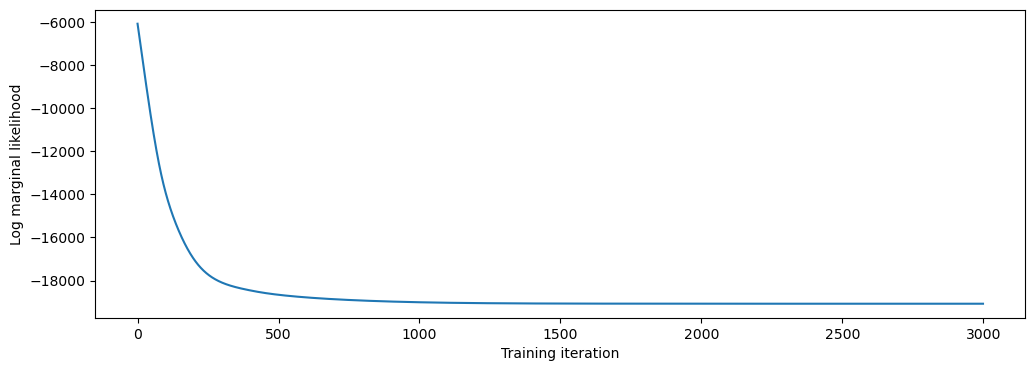

In [16]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_ )
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

## Sample from conditional GP

In [17]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.

# jibancat: Cosmological parameters in this case is in dim of 
# (n_examples, 5 features)

# predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# # Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
# predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Test input cosmologies
predictive_index_points_ = X_test

optimized_se_kernel = tfk.ExponentiatedQuadratic(
    amplitude_var, #length_scale, # feature_ndims=ndim
)
optimized_kernel = InputScaledKernel(
    optimized_se_kernel, length_scales = length_scale_var)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=X,
    observations=Y,
    # observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples = gprm.sample(num_samples)

Instructions for updating:
`always_yield_multivariate_normal` is deprecated. After 2023-02-15, this arg will be ignored, and behavior will be as though `always_yield_multivariate_normal=True`. This means that a`GaussianProcessRegressionModel` evaluated at a single index point will have event shape `[1]`. To reproduce the behavior of `always_yield_multivariate_normal=False` squeeze the rightmost singleton dimension from the output of `mean`, `sample`, etc.


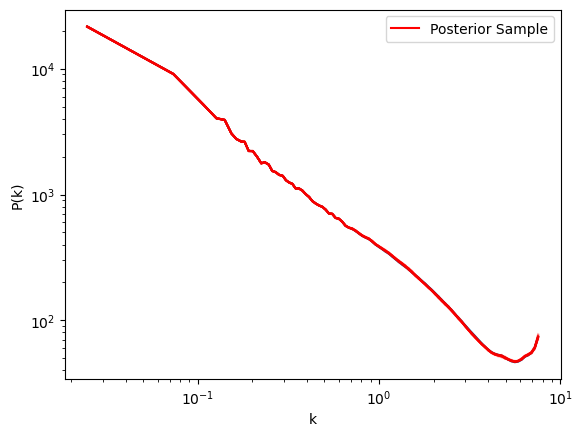

In [18]:
# plot the Pk comparison: GP predictions versus true Pk
test_i = 20

plt.loglog(10**kf, 10**(Y_test[:, test_i] + Y_mean))

for i in range(num_samples):
    plt.loglog(10**kf, 10**(samples[i, :, test_i] + Y_mean),
        c='r', alpha=.1,
        label='Posterior Sample' if i == 0 else None
    )

leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"k")
plt.ylabel("P(k)")
plt.show()

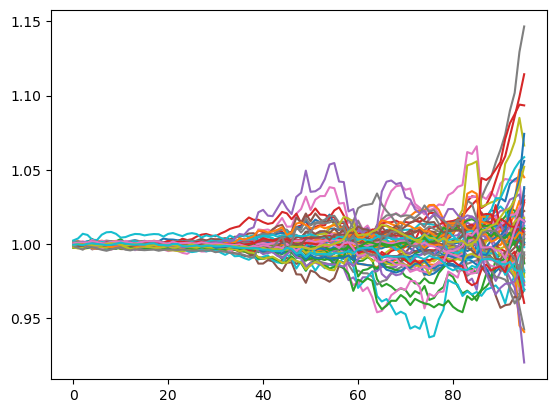

In [19]:
pred_exact = 10**(samples.numpy().mean(axis=0) + Y_mean[:, None]) / 10**(
    Y_test + Y_mean[:, None]
)
plt.plot(pred_exact);

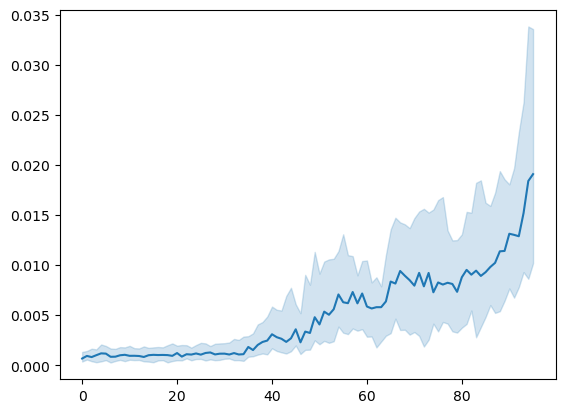

In [20]:
lower_error, median_error, upper_error = np.quantile(np.abs(pred_exact - 1), [0.25, 0.5, 0.75], axis=1)

plt.plot(median_error)
plt.fill_between(
    np.arange(pred_exact.shape[0]),
    y1=lower_error,
    y2=upper_error,
    color="C0",
    alpha=0.2
)

# jibancat save the variable for later use
_pred_exact_map = pred_exact

In [21]:
# sample from training points
gprm_train = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=X,
    observation_index_points=X,
    observations=Y,
    # observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples_train = gprm_train.sample(num_samples)

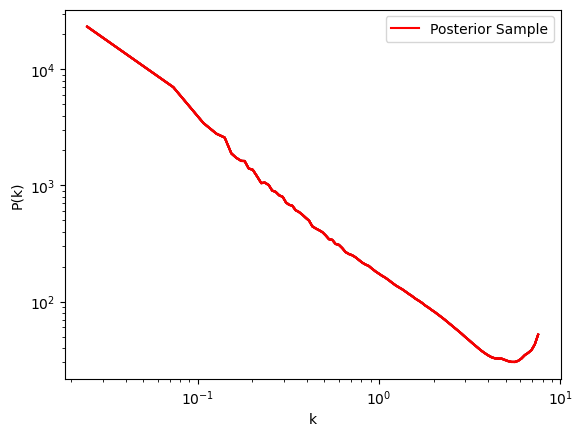

In [22]:
# plot the Pk comparison: GP predictions versus true Pk
train_i = 0

plt.loglog(10**kf, 10**(Y[:, train_i] + Y_mean))

for i in range(num_samples):
    plt.loglog(10**kf, 10**(samples_train[i, :, train_i] + Y_mean),
        c='r', alpha=.1,
        label='Posterior Sample' if i == 0 else None
    )

leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"k")
plt.ylabel("P(k)")
plt.show()

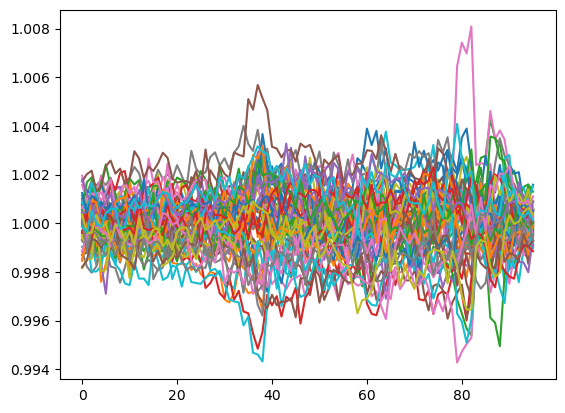

In [23]:
pred_exact_train = 10**(samples_train.numpy().mean(axis=0) + Y_mean[:, None]) / 10**(
    Y + Y_mean[:, None]
)
plt.plot(pred_exact_train);

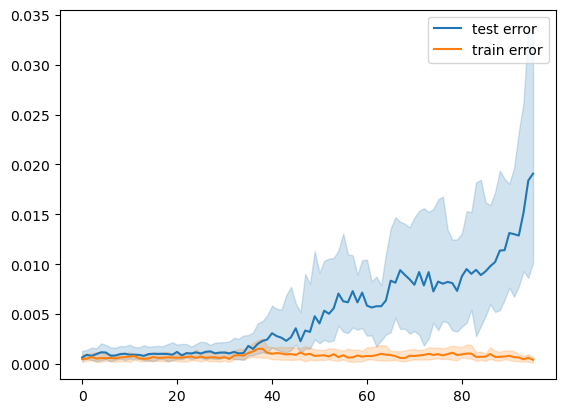

In [24]:
lower_error_train, median_error_train, upper_error_train = np.quantile(np.abs(pred_exact_train - 1), [0.25, 0.5, 0.75], axis=1)

plt.plot(median_error, label="test error")
plt.fill_between(
    np.arange(pred_exact.shape[0]),
    y1=lower_error,
    y2=upper_error,
    color="C0",
    alpha=0.2
)

plt.plot(median_error_train, color="C1", label="train error")
plt.fill_between(
    np.arange(pred_exact.shape[0]),
    y1=lower_error_train,
    y2=upper_error_train,
    color="C1",
    alpha=0.2
)

plt.legend()

## Marginalizing hyperparameters with HMC

Instead of optimizing the hyperparameters, let's try integrating them out with Hamiltonian Monte Carlo. We'll first define and run a sampler to approximately draw from the posterior distribution over kernel hyperparameters, given the observations.

The example here is not so different from tensorflow's example, except we have additional num_outputs and num_features dimensions.

In [25]:
num_results = 500
num_burnin_steps = 50

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob,
        step_size=tf.cast(0.1, tf.float64)),
    bijector=[constrain_positive, constrain_positive])

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=tf.cast(0.75, tf.float64))

# jibancat: initial values start with MAP estimation to save burning time
initial_state = [
    amplitude_var,
    length_scale_var,
]

In [26]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, jit_compile=False)
def do_sampling():
  return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=lambda current_state, kernel_results: kernel_results)

t0 = time.time()
samples, kernel_results = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Inference ran in 309.75s.


Now we have the Monte Carlo samples of hyperparameters, so we can use these posteriors to sample from GPs with different hyperparameters.

In [27]:
(amplitude_samples, length_scale_samples) = samples

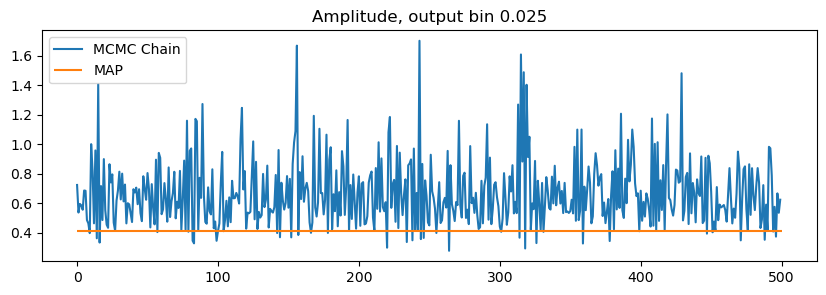

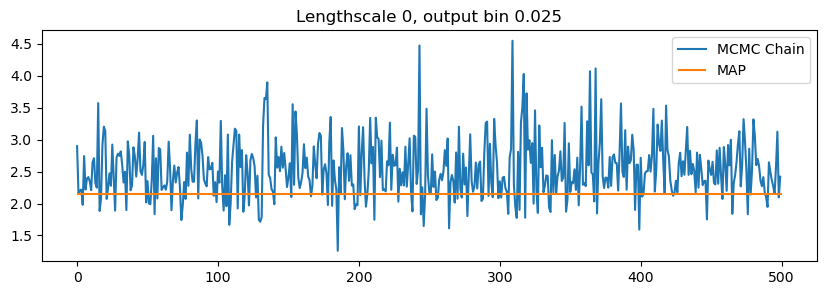

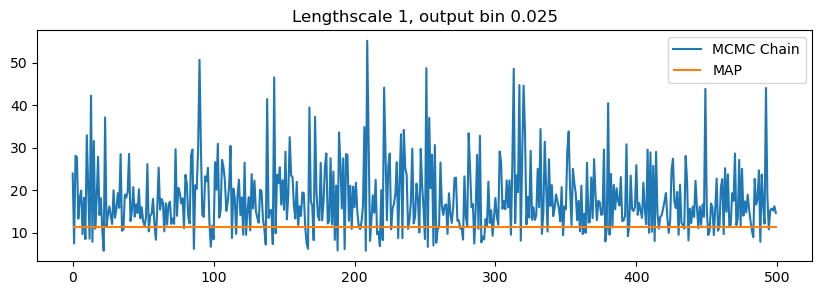

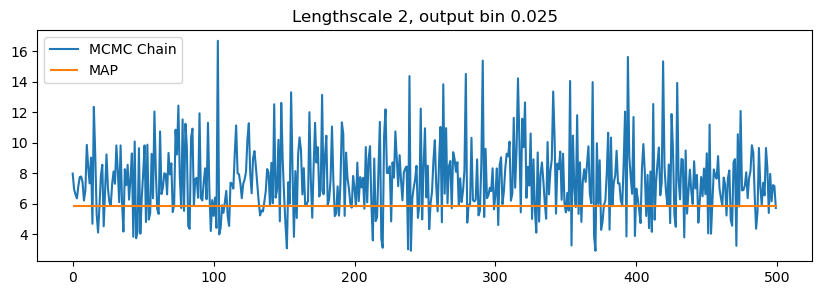

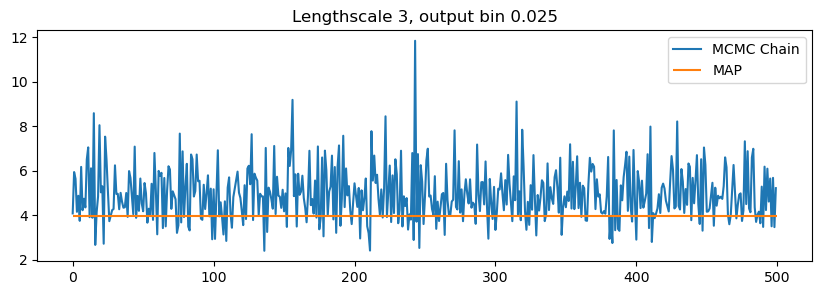

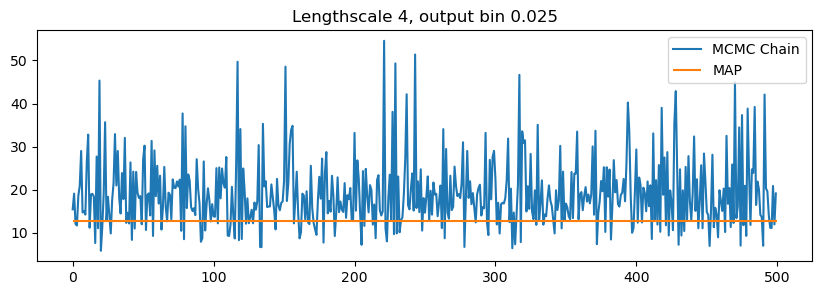

In [28]:
# check some of the chains
nth_output = 0

plt.figure(figsize=[10, 3])
plt.title("Amplitude, output bin {:.2g}".format(10**kf[nth_output]))
plt.plot(amplitude_samples[:, nth_output], label="MCMC Chain")
plt.hlines(amplitude_var[nth_output], 0, num_results, colors="C1", label="MAP")
plt.legend()
plt.show()

for i in range(num_features):
    plt.figure(figsize=[10, 3])
    plt.title("Lengthscale {}, output bin {:.2g}".format(
        i, 10**kf[nth_output])
    )
    plt.plot(length_scale_samples[:, nth_output, i], label="MCMC Chain")
    plt.hlines(length_scale_var[nth_output, i], 0, num_results, colors="C1", label="MAP")
    plt.legend()
    plt.show()

Text(0, 0.5, 'Amplitude Bin -2')

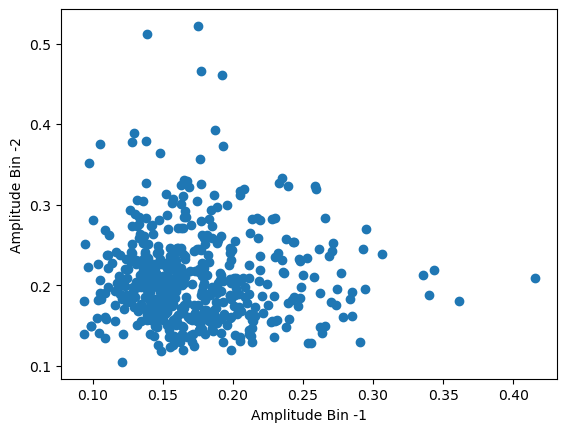

In [29]:
bin_i = -1
bin_j = -2
plt.scatter(amplitude_samples[:, bin_i], amplitude_samples[:, bin_j])

plt.xlabel("Amplitude Bin {}".format(bin_i))
plt.ylabel("Amplitude Bin {}".format(bin_j))

Text(0, 0.5, 'Lengthscale Bin 41 Feature Dim 0')

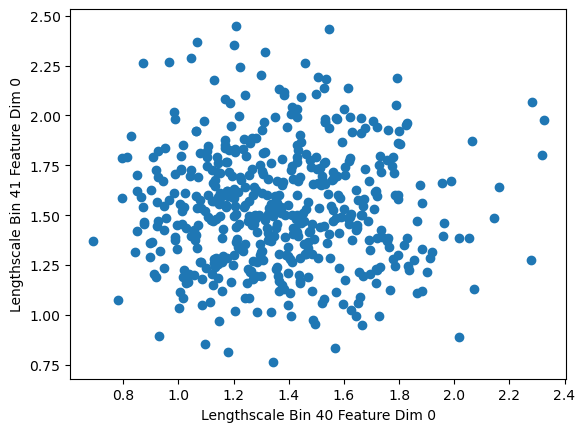

In [30]:
bin_i = 40
bin_j = 41

feature_dim = 0
plt.scatter(length_scale_samples[:, bin_i, feature_dim], length_scale_samples[:, bin_j, feature_dim])

plt.xlabel("Lengthscale Bin {} Feature Dim {}".format(bin_i, feature_dim))
plt.ylabel("Lengthscale Bin {} Feature Dim {}".format(bin_j, feature_dim))

Text(0, 0.5, 'Lengthscale Bin 0 Feature Dim 0')

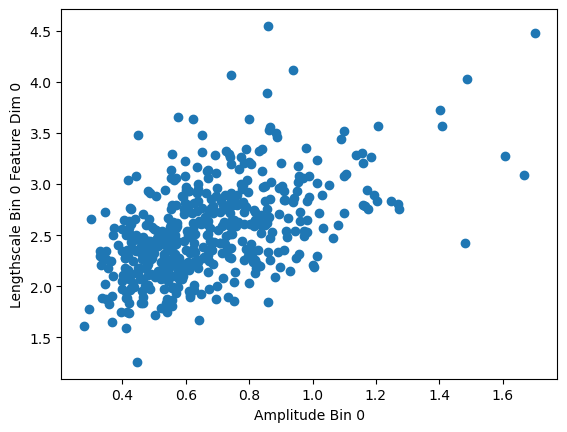

In [31]:
bin_i = 0
bin_j = 0

feature_dim = 0

plt.scatter(amplitude_samples[:, bin_i], length_scale_samples[:, bin_j, feature_dim])

plt.xlabel("Amplitude Bin {}".format(bin_i))
plt.ylabel("Lengthscale Bin {} Feature Dim {}".format(bin_j, feature_dim))

Jibancat: It seems like the samples are too few! But to sample more requires very long time. Probably better to put on a cluster to run the chains (or enable the GPU).

Now instead of constructing a single GP with the optimized hyperparameters, we construct the *posterior predictive distribution* as a mixture of GPs, each defined by a sample from the posterior distribution over hyperparameters. This approximately integrates over the posterior parameters via Monte Carlo sampling to compute the marginal predictive distribution at unobserved locations.

In [32]:
# The sampled hyperparams have a leading batch dimension, `[num_results, ...]`,
# so they construct a *batch* of kernels.
batch_of_posterior_se_kernel = tfk.ExponentiatedQuadratic(
    amplitude_samples, #length_scale, # feature_ndims=ndim
)
batch_of_posterior_kernels = InputScaledKernel(
    batch_of_posterior_se_kernel, length_scales = length_scale_samples)

# Test input cosmologies
predictive_index_points_ = X_test

# The batch of kernels creates a batch of GP predictive models, one for each
# posterior sample.

batch_gprm = tfd.GaussianProcessRegressionModel(
    kernel=batch_of_posterior_kernels,
    index_points=predictive_index_points_,
    observation_index_points=X,
    observations=Y,
    # observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# To construct the marginal predictive distribution, we average with uniform
# weight over the posterior samples.
predictive_gprm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        logits=tf.zeros([num_results])
    ),
    # jibancat: This is a tricky bit of code.
    #           basically you need to reinterpret the output_dim
    #           as part of the distribution, not the batch_dim.
    components_distribution=tfd.Independent(
        batch_gprm, reinterpreted_batch_ndims=1),
    )

In [33]:
num_samples = 100
samples = predictive_gprm.sample(num_samples)

jibancat: Running the above cell costs me ~30 GB on memory of laptop during the peak value when I used 310 examples for training.

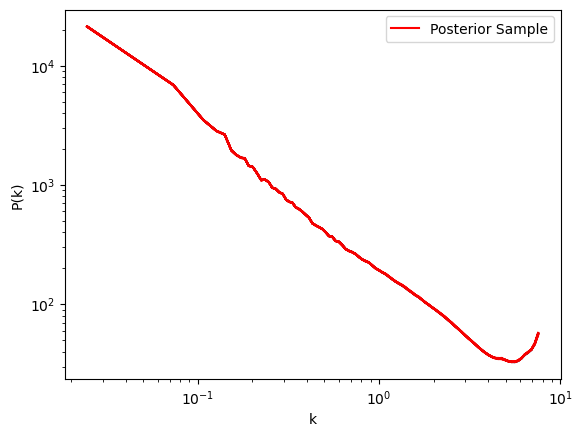

In [34]:
# plot the Pk comparison: GP predictions versus true Pk
test_i = 0

plt.loglog(10**kf, 10**(Y_test[:, test_i] + Y_mean))

for i in range(num_samples):
    plt.loglog(10**kf, 10**(samples[i, :, test_i] + Y_mean),
        c='r', alpha=.1,
        label='Posterior Sample' if i == 0 else None
    )

leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"k")
plt.ylabel("P(k)")
plt.show()

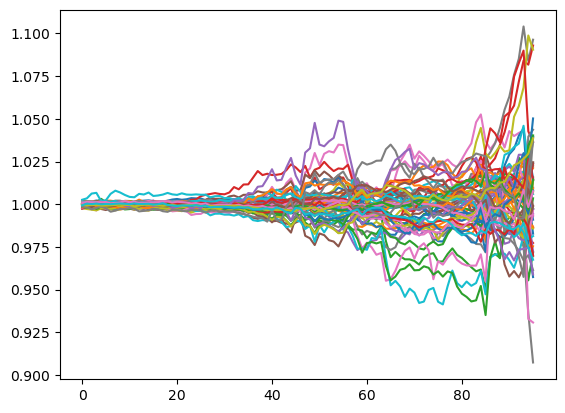

In [35]:
pred_exact = 10**(samples.numpy().mean(axis=0) + Y_mean[:, None]) / 10**(
    Y_test + Y_mean[:, None]
)
plt.plot(pred_exact);

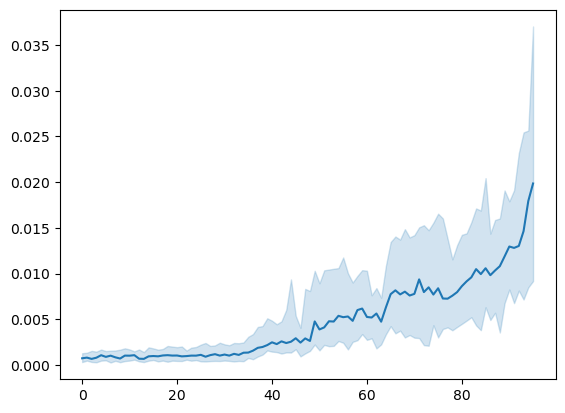

In [36]:
lower_error, median_error, upper_error = np.quantile(np.abs(pred_exact - 1), [0.25, 0.5, 0.75], axis=1)

plt.plot(median_error)
plt.fill_between(
    np.arange(pred_exact.shape[0]),
    y1=lower_error,
    y2=upper_error,
    color="C0",
    alpha=0.2
)

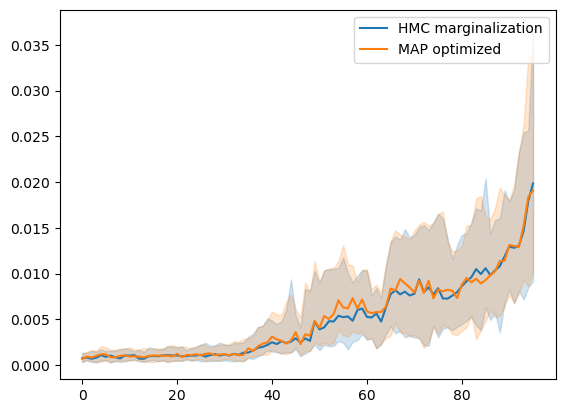

In [37]:
lower_error, median_error, upper_error = np.quantile(np.abs(pred_exact - 1), [0.25, 0.5, 0.75], axis=1)

plt.plot(median_error, label="HMC marginalization")
plt.fill_between(
    np.arange(pred_exact.shape[0]),
    y1=lower_error,
    y2=upper_error,
    color="C0",
    alpha=0.2
)

lower_error, median_error, upper_error = np.quantile(np.abs(_pred_exact_map - 1), [0.25, 0.5, 0.75], axis=1)

plt.plot(median_error, color="C1", label="MAP optimized")
plt.fill_between(
    np.arange(pred_exact.shape[0]),
    y1=lower_error,
    y2=upper_error,
    color="C1",
    alpha=0.2
)

plt.legend()

In [38]:
import h5py

with h5py.File("../data/360_res128box256_9_res512box256_z0/hmc_samples_lf_60.hdf5", "w") as f:
    f.create_dataset("length_scale_samples", data=length_scale_samples.numpy())
    f.create_dataset("amplitude_samples", data=amplitude_samples.numpy())
    f.create_dataset("predictive_samples", data=samples.numpy())